In [1]:
import os

class cfg():
    data_path = "/Users/user/Desktop/Algorun_24/data"

    seed = 42

    holidays_path = os.path.join(data_path, "holidays.csv")
    products_path = os.path.join(data_path, "products.csv")
    promotions_path = os.path.join(data_path, "promotions.csv")
    sample_submission_path = os.path.join(data_path, "sample_submission.csv")
    test_path = os.path.join(data_path, "test.csv")
    train_path = os.path.join(data_path, "train.csv")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [3]:
holidays_df = pd.read_csv(cfg.holidays_path)
products_df = pd.read_csv(cfg.products_path)
promotions_df = pd.read_csv(cfg.promotions_path)
sample_submission_df = pd.read_csv(cfg.sample_submission_path, delimiter='|')
test_df = pd.read_csv(cfg.test_path)
train_df = pd.read_csv(cfg.train_path)

In [4]:
# Convert columns to datetime format

train_df["week_starting_date"] = pd.to_datetime(train_df["week_starting_date"])
test_df["week_starting_date"] = pd.to_datetime(test_df["week_starting_date"])
sample_submission_df["week_starting_date"] = pd.to_datetime(sample_submission_df["week_starting_date"])


In [5]:
train_df

,product_id,week_starting_date,sales_quantity,inventory,sales_revenue,price_without_tax,initial_price
0,0,2022-07-14,8.0,NaN,37.12,NaN,NaN
1,0,2023-07-13,7.0,NaN,34.50,NaN,NaN
2,0,2023-10-05,3.0,NaN,13.11,NaN,NaN
3,1,2023-03-23,2.0,NaN,7.50,NaN,NaN
4,4,2024-06-13,0.0,0.0,0.00,69.99,69.99
...,...,...,...,...,...,...,...
1763854,89712,2022-05-26,11.0,136.0,249.47,29.98,34.99
1763855,89712,2022-10-06,2.0,5.0,38.65,25.98,34.99
1763856,89715,2022-04-07,130.0,6670.0,6041.07,49.99,59.99
1763857,89715,2023-01-12,92.0,2713.0,4918.02,54.99,59.99


In [6]:
# Sort the data by product_id and week_starting_date
train_df = train_df.sort_values(['product_id', 'week_starting_date'])

# Create lagged features for inventory and sales
def create_lagged_features(df, lag_periods=[1, 2, 3, 4]):
    for lag in lag_periods:
        # Create lagged inventory
        df[f'inventory_lag_{lag}'] = df.groupby('product_id')['inventory'].shift(lag)
        # Create lagged sales
        df[f'sales_quantity_lag_{lag}'] = df.groupby('product_id')['sales_quantity'].shift(lag)
    return df

# Apply the function
train_df = create_lagged_features(train_df)


In [7]:
# Calculate correlation between lagged inventory and sales
correlation_analysis = pd.DataFrame()
for lag in [1, 2, 3, 4]:
    correlation = train_df[f'inventory_lag_{lag}'].corr(train_df['sales_quantity'])
    correlation_analysis.loc[f'Lag {lag}', 'Correlation'] = correlation

print("Correlation between lagged inventory and sales:")
print(correlation_analysis)


Correlation between lagged inventory and sales:
       Correlation
Lag 1     0.798107
Lag 2     0.794400
Lag 3     0.786876
Lag 4     0.776034


In [8]:
def analyze_inventory_sales_relationship(df):
    # Calculate average sales for different inventory levels
    df['inventory_bins'] = pd.qcut(df['inventory'], q=10, duplicates='drop')
    
    analysis = df.groupby('inventory_bins').agg({
        'sales_quantity': ['mean', 'median', 'std', 'count'],
        'sales_revenue': ['mean', 'sum']
    }).round(2)
    
    return analysis

# Remove rows where inventory is NaN
valid_data = train_df.dropna(subset=['inventory'])
inventory_sales_analysis = analyze_inventory_sales_relationship(valid_data)
print("\nInventory-Sales Relationship Analysis:")
print(inventory_sales_analysis)



Inventory-Sales Relationship Analysis:
                  sales_quantity                        sales_revenue  \
                            mean median     std   count          mean   
inventory_bins                                                          
(-0.001, 1.0]               0.05    0.0    2.67  310060          1.33   
(1.0, 3.0]                  0.16    0.0    1.52  133975          4.25   
(3.0, 7.0]                  0.33    0.0    0.89  113694          8.46   
(7.0, 22.0]                 0.91    0.0    1.51  133602         22.72   
(22.0, 89.0]                3.36    2.0    3.59  136179         93.01   
(89.0, 353.0]              11.89    9.0   11.13  138021        385.95   
(353.0, 1161.0]            37.75   30.0   33.33  137637       1487.01   
(1161.0, 3384.0]          108.09   86.0   94.31  137908       4522.59   
(3384.0, 74965.0]         357.74  271.0  342.09  137875      15727.58   

                                 
                            sum  
inventory_bins 

/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_1238/1500135559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['inventory_bins'] = pd.qcut(df['inventory'], q=10, duplicates='drop')


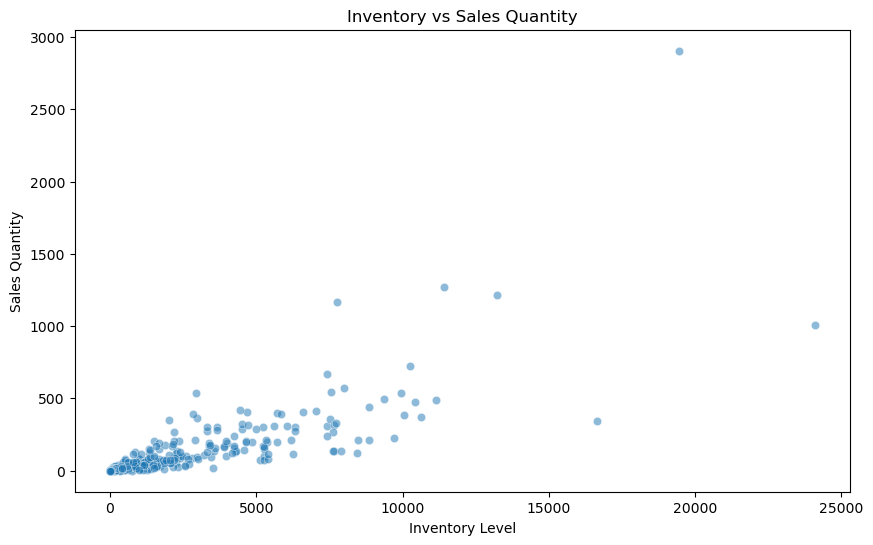

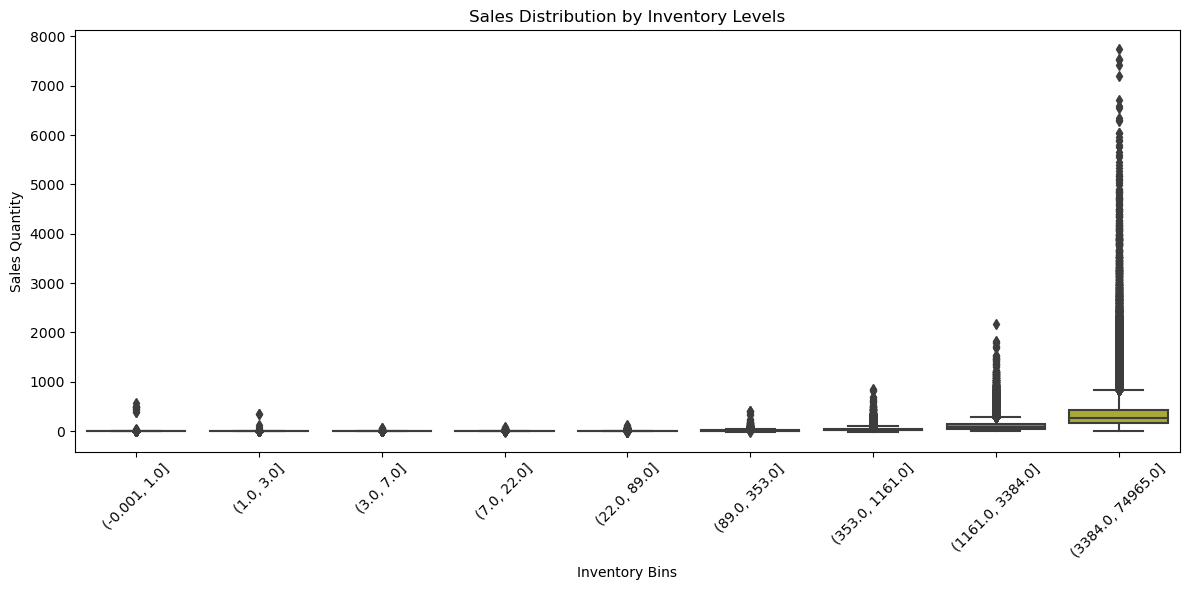

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_df.sample(1000), x='inventory', y='sales_quantity', alpha=0.5)
plt.title('Inventory vs Sales Quantity')
plt.xlabel('Inventory Level')
plt.ylabel('Sales Quantity')
plt.show()

# Create box plot for inventory bins vs sales
plt.figure(figsize=(12, 6))
sns.boxplot(data=valid_data, x='inventory_bins', y='sales_quantity')
plt.xticks(rotation=45)
plt.title('Sales Distribution by Inventory Levels')
plt.xlabel('Inventory Bins')
plt.ylabel('Sales Quantity')
plt.tight_layout()
plt.show()


In [10]:
import pandas as pd
import numpy as np

def create_future_sales_features(df):
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create future sales features for next 1-4 weeks
    for i in range(1, 5):
        # Shift sales quantity backwards to get future sales
        df[f'sales_quantity_{i}w_later'] = df.groupby('product_id')['sales_quantity'].shift(-i)
        df[f'sales_revenue_{i}w_later'] = df.groupby('product_id')['sales_revenue'].shift(-i)
        
        # Calculate the ratio of sales to inventory (if inventory > 0)
        df[f'sales_to_inventory_ratio_{i}w_later'] = np.where(
            df['inventory'] > 0,
            df[f'sales_quantity_{i}w_later'] / df['inventory'],
            np.nan
        )
        
        # Calculate inventory turnover rate
        df[f'inventory_turnover_{i}w_later'] = np.where(
            df['inventory'] > 0,
            df[f'sales_revenue_{i}w_later'] / df['inventory'],
            np.nan
        )

    return df

def analyze_inventory_sales_relationship(df):
    # Create the features
    df_analysis = create_future_sales_features(df)
    
    # Calculate correlations between inventory and future sales
    inventory_cols = ['inventory']
    future_sales_cols = [col for col in df_analysis.columns if '_later' in col]
    
    correlation_matrix = df_analysis[inventory_cols + future_sales_cols].corr()
    
    # Calculate summary statistics
    summary_stats = df_analysis.groupby('product_id').agg({
        'inventory': 'mean',
        'sales_quantity': 'mean',
        **{f'sales_quantity_{i}w_later': 'mean' for i in range(1, 5)},
        **{f'sales_to_inventory_ratio_{i}w_later': 'mean' for i in range(1, 5)},
        **{f'inventory_turnover_{i}w_later': 'mean' for i in range(1, 5)}
    }).reset_index()
    
    return df_analysis, correlation_matrix, summary_stats

# Use the functions
df_analyzed, correlations, summary = analyze_inventory_sales_relationship(train_df)

# Example of how to analyze the results
def print_analysis(df_analyzed, correlations, summary):
    print("Correlation between inventory and future sales:")
    print(correlations.loc['inventory'].sort_values(ascending=False))
    
    print("\nAverage metrics across all products:")
    print(summary.mean())
    
    # Additional analysis: Calculate percentage of products with different inventory-sales patterns
    for i in range(1, 5):
        sales_col = f'sales_quantity_{i}w_later'
        ratio = (df_analyzed[sales_col] > df_analyzed['sales_quantity']).mean()
        print(f"\nPercentage of cases where sales {i} week(s) later were higher than current week: {ratio*100:.2f}%")

# Print the analysis
print_analysis(df_analyzed, correlations, summary)


Correlation between inventory and future sales:
inventory                            1.000000
sales_quantity_1w_later              0.798107
sales_quantity_2w_later              0.794400
sales_quantity_3w_later              0.786876
sales_quantity_4w_later              0.776034
sales_revenue_1w_later               0.717303
sales_revenue_2w_later               0.712788
sales_revenue_3w_later               0.704886
sales_revenue_4w_later               0.694449
inventory_turnover_1w_later         -0.002184
inventory_turnover_3w_later         -0.004331
inventory_turnover_2w_later         -0.004836
inventory_turnover_4w_later         -0.005105
sales_to_inventory_ratio_1w_later   -0.006130
sales_to_inventory_ratio_3w_later   -0.007015
sales_to_inventory_ratio_4w_later   -0.007594
sales_to_inventory_ratio_2w_later   -0.007695
Name: inventory, dtype: float64

Average metrics across all products:
product_id                           43589.548065
inventory                              418.460842


In [11]:
import pandas as pd
import numpy as np

def analyze_inventory_sales_patterns(df):
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create shifted inventory columns (past inventory levels)
    df['inventory_1w_before'] = df.groupby('product_id')['inventory'].shift(1)
    df['inventory_2w_before'] = df.groupby('product_id')['inventory'].shift(2)
    
    # Analysis of sales based on past inventory situations
    def analyze_inventory_impact():
        # Case 1: Zero inventory in previous week
        zero_inv_prev_week = df[df['inventory_1w_before'] == 0].agg({
            'sales_quantity': ['count', 'mean', 'median', 'std'],
            'sales_revenue': ['mean', 'median']
        })
        
        # Case 2: Low inventory in previous week (below 25th percentile)
        low_inv_threshold = df['inventory_1w_before'].quantile(0.25)
        low_inv_prev_week = df[df['inventory_1w_before'] <= low_inv_threshold].agg({
            'sales_quantity': ['count', 'mean', 'median', 'std'],
            'sales_revenue': ['mean', 'median']
        })
        
        # Case 3: High inventory in previous week (above 75th percentile)
        high_inv_threshold = df['inventory_1w_before'].quantile(0.75)
        high_inv_prev_week = df[df['inventory_1w_before'] >= high_inv_threshold].agg({
            'sales_quantity': ['count', 'mean', 'median', 'std'],
            'sales_revenue': ['mean', 'median']
        })
        
        return {
            'zero_inventory': zero_inv_prev_week,
            'low_inventory': low_inv_prev_week,
            'high_inventory': high_inv_prev_week
        }
    
    # Calculate week-over-week changes
    df['inventory_wow_change'] = df['inventory'] - df['inventory_1w_before']
    df['sales_wow_change'] = df['sales_quantity'] - df.groupby('product_id')['sales_quantity'].shift(1)
    
    # Group products by inventory patterns
    def categorize_inventory_patterns():
        patterns = {}
        
        # Products with consistently zero inventory
        zero_inv_products = df.groupby('product_id').apply(
            lambda x: (x['inventory_1w_before'] == 0).mean() > 0.8
        )
        patterns['consistent_zero_inventory'] = zero_inv_products[zero_inv_products].index.tolist()
        
        # Products with volatile inventory
        inventory_volatility = df.groupby('product_id')['inventory'].std()
        volatile_products = inventory_volatility[
            inventory_volatility > inventory_volatility.quantile(0.75)
        ].index.tolist()
        patterns['volatile_inventory'] = volatile_products
        
        return patterns
    
    # Calculate sales performance metrics
    def calculate_sales_metrics():
        metrics = df.groupby('product_id').agg({
            'sales_quantity': ['mean', 'std'],
            'inventory_1w_before': ['mean', 'std'],
            'sales_revenue': 'sum'
        }).round(2)
        
        # Calculate inventory turnover rate
        metrics['inventory_turnover'] = df.groupby('product_id').apply(
            lambda x: (x['sales_quantity'].sum() / x['inventory_1w_before'].mean())
            if x['inventory_1w_before'].mean() > 0 else np.nan
        )
        
        return metrics
    
    results = {
        'inventory_impact_analysis': analyze_inventory_impact(),
        'inventory_patterns': categorize_inventory_patterns(),
        'sales_metrics': calculate_sales_metrics()
    }
    
    return df, results

# Use the function
df_analyzed, analysis_results = analyze_inventory_sales_patterns(train_df)

# Print the analysis
def print_detailed_analysis(df, results):
    print("1. Impact of Previous Week's Inventory on Sales:")
    print("\nA. When previous week inventory was zero:")
    print(results['inventory_impact_analysis']['zero_inventory'])
    
    print("\nB. When previous week inventory was low:")
    print(results['inventory_impact_analysis']['low_inventory'])
    
    print("\nC. When previous week inventory was high:")
    print(results['inventory_impact_analysis']['high_inventory'])
    
    print("\n2. Products with Special Inventory Patterns:")
    print(f"Number of products with consistently zero inventory: {len(results['inventory_patterns']['consistent_zero_inventory'])}")
    print(f"Number of products with volatile inventory: {len(results['inventory_patterns']['volatile_inventory'])}")
    
    print("\n3. Overall Sales Metrics:")
    print(results['sales_metrics'].head())
    
    # Additional analysis of inventory-sales relationships
    print("\n4. Inventory-Sales Relationship Analysis:")
    df['has_inventory'] = df['inventory_1w_before'] > 0
    sales_by_inventory = df.groupby('has_inventory')['sales_quantity'].agg(['mean', 'median', 'count'])
    print("\nSales comparison based on inventory availability:")
    print(sales_by_inventory)

# Print the analysis
print_detailed_analysis(df_analyzed, analysis_results)


1. Impact of Previous Week's Inventory on Sales:

A. When previous week inventory was zero:
        sales_quantity  sales_revenue
count    146546.000000            NaN
mean          0.137609       6.851109
median        0.000000       0.000000
std           4.269596            NaN

B. When previous week inventory was low:
        sales_quantity  sales_revenue
count    361365.000000            NaN
mean          0.155494       5.898713
median        0.000000       0.000000
std           4.545509            NaN

C. When previous week inventory was high:
        sales_quantity  sales_revenue
count    333597.000000            NaN
mean        199.357362    8633.495267
median      117.000000    4118.590000
std         263.912033            NaN

2. Products with Special Inventory Patterns:
Number of products with consistently zero inventory: 1735
Number of products with volatile inventory: 11661

3. Overall Sales Metrics:
           sales_quantity        inventory_1w_before          sales_reve

In [12]:
import pandas as pd
import numpy as np

def analyze_inventory_sales_relationship(df):
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create past inventory columns
    df['prev_week_inventory'] = df.groupby('product_id')['inventory'].shift(1)
    df['prev_2week_inventory'] = df.groupby('product_id')['inventory'].shift(2)
    
    # Remove rows with NaN values for meaningful analysis
    df_clean = df.dropna(subset=['inventory', 'prev_week_inventory', 'sales_quantity'])
    
    # Create inventory categories for previous week
    df_clean['prev_inventory_category'] = pd.cut(
        df_clean['prev_week_inventory'],
        bins=[-np.inf, 0, 10, 50, 100, np.inf],
        labels=['No Stock', 'Very Low', 'Low', 'Medium', 'High']
    )
    
    # Analysis by previous week's inventory levels
    inventory_analysis = df_clean.groupby('prev_inventory_category').agg({
        'sales_quantity': ['count', 'mean', 'median', 'std'],
        'sales_revenue': ['mean', 'sum'],
        'inventory': 'mean'
    }).round(2)
    
    # Calculate stock-out impact
    stockout_analysis = {
        'after_stockout': df_clean[df_clean['prev_week_inventory'] == 0]['sales_quantity'].describe(),
        'with_stock': df_clean[df_clean['prev_week_inventory'] > 0]['sales_quantity'].describe()
    }
    
    # Calculate sales performance by inventory ranges
    def get_sales_performance(row):
        if row['prev_week_inventory'] == 0:
            return 'No Previous Inventory'
        elif row['sales_quantity'] == 0:
            return 'No Sales'
        elif row['sales_quantity'] <= row['prev_week_inventory']:
            return 'Normal Sales'
        else:
            return 'Sales Exceeded Previous Inventory'
    
    df_clean['sales_performance'] = df_clean.apply(get_sales_performance, axis=1)
    performance_analysis = df_clean.groupby('sales_performance').agg({
        'product_id': 'count',
        'sales_quantity': ['mean', 'sum'],
        'sales_revenue': 'sum'
    }).round(2)
    
    return {
        'inventory_analysis': inventory_analysis,
        'stockout_analysis': stockout_analysis,
        'performance_analysis': performance_analysis,
        'detailed_data': df_clean
    }

# Run the analysis
results = analyze_inventory_sales_relationship(train_df)

# Print results
print("1. Sales Analysis by Previous Week's Inventory Levels:")
print(results['inventory_analysis'])
print("\n2. Impact of Stock-outs vs. Having Stock:")
print("\nAfter Stock-out Statistics:")
print(results['stockout_analysis']['after_stockout'])
print("\nWith Stock Statistics:")
print(results['stockout_analysis']['with_stock'])
print("\n3. Sales Performance Analysis:")
print(results['performance_analysis'])

# Additional specific analyses
detailed_data = results['detailed_data']

# Calculate average sales by inventory ranges
print("\n4. Average Sales by Previous Week's Inventory Ranges:")
inventory_ranges = pd.qcut(detailed_data['prev_week_inventory'], q=5)
avg_sales = detailed_data.groupby(inventory_ranges)['sales_quantity'].mean().round(2)
print(avg_sales)

# Calculate probability of stock-out based on previous inventory
print("\n5. Stock-out Probability Analysis:")
detailed_data['next_week_stockout'] = detailed_data.groupby('product_id')['inventory'].shift(-1) == 0
stockout_prob = detailed_data.groupby('prev_inventory_category')['next_week_stockout'].mean().round(3)
print(stockout_prob)


# Add these inside the main function for more detailed analysis

# Weekly sales patterns after stock-outs
recovery_pattern = detailed_data[detailed_data['prev_week_inventory'] == 0].groupby('product_id').agg({
    'sales_quantity': ['mean', 'max'],
    'inventory': 'mean'
}).round(2)

# Inventory efficiency
detailed_data['inventory_efficiency'] = np.where(
    detailed_data['prev_week_inventory'] > 0,
    detailed_data['sales_quantity'] / detailed_data['prev_week_inventory'],
    np.nan
)

# Optimal inventory analysis
optimal_inventory = detailed_data.groupby('product_id').agg({
    'sales_quantity': 'mean',
    'prev_week_inventory': 'mean',
    'inventory_efficiency': 'mean'
}).round(2)




/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_1238/2302845950.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['prev_inventory_category'] = pd.cut(
/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_1238/2302845950.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sales_performance'] = df_clean.apply(get_sales_performance, axis=1)


1. Sales Analysis by Previous Week's Inventory Levels:
                        sales_quantity                        sales_revenue  \
                                 count    mean median     std          mean   
prev_inventory_category                                                       
No Stock                        146546    0.14    0.0    4.27          6.85   
Very Low                        413468    0.29    0.0    5.26          9.04   
Low                             166632    1.76    1.0    8.46         50.10   
Medium                           65256    4.84    4.0    9.42        145.74   
High                            535249  131.08   50.0  226.62       5623.60   

                                      inventory  
                                  sum      mean  
prev_inventory_category                          
No Stock                 1.004003e+06      4.14  
Very Low                 3.738478e+06      4.84  
Low                      8.348201e+06     27.10  
Medium      

In [13]:
import pandas as pd
import numpy as np

train_df = pd.read_csv(cfg.train_path)

def analyze_inventory_sales_relationship(df):
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create past inventory columns
    df['prev_week_inventory'] = df.groupby('product_id')['inventory'].shift(1)
    df['prev_2week_inventory'] = df.groupby('product_id')['inventory'].shift(2)
    
    # Remove rows with NaN values for meaningful analysis
    df_clean = df.dropna(subset=['inventory', 'prev_week_inventory', 'sales_quantity'])
    
    # Create more detailed inventory categories for previous week
    df_clean['prev_inventory_category'] = pd.cut(
        df_clean['prev_week_inventory'],
        bins=[-np.inf, 0, 5, 10, 25, 50, 100, 250, 500, 1000, np.inf],
        labels=['No Stock', 'Very Low (1-5)', 'Low (6-10)', 'Low-Med (11-25)', 
                'Medium (26-50)', 'Med-High (51-100)', 'High (101-250)', 
                'Very High (251-500)', 'Extra High (501-1000)', 'Massive (1000+)']
    )
    
    # Analysis by previous week's inventory levels
    inventory_analysis = df_clean.groupby('prev_inventory_category').agg({
        'sales_quantity': ['count', 'mean', 'median', 'std'],
        'sales_revenue': ['mean', 'sum'],
        'inventory': 'mean'
    }).round(2)
    
    # Detailed sales analysis by inventory ranges
    detailed_ranges = pd.qcut(df_clean['prev_week_inventory'], q=20, duplicates='drop')
    detailed_sales_analysis = df_clean.groupby(detailed_ranges).agg({
        'sales_quantity': ['count', 'mean', 'median', 'std'],
        'sales_revenue': ['mean', 'sum'],
        'product_id': 'nunique'
    }).round(2)
    
    # Calculate additional metrics for each range
    detailed_sales_analysis['sales_to_inventory_ratio'] = (
        detailed_sales_analysis[('sales_quantity', 'mean')] / 
        detailed_sales_analysis.index.map(lambda x: x.right)
    ).round(3)
    
    # Stock-out impact analysis
    stockout_analysis = {
        'after_stockout': df_clean[df_clean['prev_week_inventory'] == 0]['sales_quantity'].describe(),
        'with_stock': df_clean[df_clean['prev_week_inventory'] > 0]['sales_quantity'].describe()
    }
    
    # Sales performance categorization
    def get_sales_performance(row):
        if row['prev_week_inventory'] == 0:
            return 'No Previous Inventory'
        elif row['sales_quantity'] == 0:
            return 'No Sales'
        elif row['sales_quantity'] <= row['prev_week_inventory'] * 0.25:
            return 'Low Sales (≤25% of inventory)'
        elif row['sales_quantity'] <= row['prev_week_inventory'] * 0.5:
            return 'Moderate Sales (26-50% of inventory)'
        elif row['sales_quantity'] <= row['prev_week_inventory']:
            return 'High Sales (51-100% of inventory)'
        else:
            return 'Sales Exceeded Inventory'
    
    df_clean['sales_performance'] = df_clean.apply(get_sales_performance, axis=1)
    performance_analysis = df_clean.groupby('sales_performance').agg({
        'product_id': 'count',
        'sales_quantity': ['mean', 'sum'],
        'sales_revenue': 'sum',
        'prev_week_inventory': 'mean'
    }).round(2)
    
    return {
        'inventory_analysis': inventory_analysis,
        'detailed_sales_analysis': detailed_sales_analysis,
        'stockout_analysis': stockout_analysis,
        'performance_analysis': performance_analysis,
        'detailed_data': df_clean
    }

# Run the analysis
results = analyze_inventory_sales_relationship(train_df)

# Print results
print("1. Sales Analysis by Previous Week's Inventory Levels (10 Categories):")
print(results['inventory_analysis'])

print("\n2. Detailed Sales Analysis by Inventory Ranges (20 Quantiles):")
print(results['detailed_sales_analysis'])

print("\n3. Impact of Stock-outs vs. Having Stock:")
print("\nAfter Stock-out Statistics:")
print(results['stockout_analysis']['after_stockout'])
print("\nWith Stock Statistics:")
print(results['stockout_analysis']['with_stock'])

print("\n4. Sales Performance Analysis:")
print(results['performance_analysis'])

# Additional analysis for specific inventory ranges
detailed_data = results['detailed_data']

# Calculate probability of stock-out based on previous inventory
print("\n5. Stock-out Probability Analysis by Inventory Category:")
detailed_data['next_week_stockout'] = detailed_data.groupby('product_id')['inventory'].shift(-1) == 0
stockout_prob = detailed_data.groupby('prev_inventory_category')['next_week_stockout'].agg(['mean', 'count']).round(3)
print(stockout_prob)

# Calculate average sales efficiency by inventory category
print("\n6. Sales Efficiency by Inventory Category:")
detailed_data['sales_efficiency'] = np.where(
    detailed_data['prev_week_inventory'] > 0,
    detailed_data['sales_quantity'] / detailed_data['prev_week_inventory'],
    np.nan
)
efficiency_analysis = detailed_data.groupby('prev_inventory_category')['sales_efficiency'].agg(['mean', 'median', 'std']).round(3)
print(efficiency_analysis)


/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_1238/3078902905.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['prev_inventory_category'] = pd.cut(


TypeError: Object with dtype category cannot perform the numpy op divide

In [ ]:
import pandas as pd
import numpy as np

def analyze_inventory_sales_patterns(df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create past inventory column
    df['prev_week_inventory'] = df.groupby('product_id')['inventory'].shift(1)
    
    # Remove rows with NaN values
    df_clean = df.dropna(subset=['inventory', 'prev_week_inventory', 'sales_quantity'])
    
    # Create inventory bins using quantiles for more even distribution
    quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
    bins = [df_clean['prev_week_inventory'].quantile(q) for q in quantiles]
    bins[0] = -np.inf  # Replace first bin edge with -inf
    
    # Create labels for the bins
    labels = [
        f'{bins[i]:.0f}-{bins[i+1]:.0f}'
        for i in range(len(bins)-1)
    ]
    
    # Create inventory categories
    df_clean['inventory_category'] = pd.cut(
        df_clean['prev_week_inventory'],
        bins=bins,
        labels=labels
    )
    
    # Analysis by inventory category
    analysis = df_clean.groupby('inventory_category').agg({
        'sales_quantity': ['count', 'mean', 'median', 'std'],
        'sales_revenue': ['mean', 'sum'],
        'product_id': 'nunique'
    }).round(2)
    
    # Add percentage of zero sales
    zero_sales = df_clean.groupby('inventory_category')['sales_quantity'].apply(
        lambda x: (x == 0).mean() * 100
    ).round(2)
    analysis[('sales_quantity', 'zero_sales_pct')] = zero_sales
    
    # Calculate average sales to inventory ratio
    df_clean['sales_to_inventory_ratio'] = np.where(
        df_clean['prev_week_inventory'] > 0,
        df_clean['sales_quantity'] / df_clean['prev_week_inventory'],
        np.nan
    )
    
    ratio_analysis = df_clean.groupby('inventory_category')['sales_to_inventory_ratio'].agg([
        'mean', 'median'
    ]).round(3)
    
    return analysis, ratio_analysis, df_clean

# Run the analysis
analysis, ratio_analysis, df_clean = analyze_inventory_sales_patterns(train_df)

# Print results
print("\n1. Sales Analysis by Previous Week's Inventory Levels:")
print(analysis)

print("\n2. Sales-to-Inventory Ratio Analysis:")
print(ratio_analysis)

# Additional summary statistics
print("\n3. Overall Statistics:")
print(f"Total observations: {len(df_clean):,}")
print(f"Unique products: {df_clean['product_id'].nunique():,}")
print(f"Average sales quantity: {df_clean['sales_quantity'].mean():.2f}")
print(f"Median sales quantity: {df_clean['sales_quantity'].median():.2f}")

# Calculate next week stockout probability
df_clean['next_week_stockout'] = df_clean.groupby('product_id')['inventory'].shift(-1) == 0
stockout_prob = df_clean.groupby('inventory_category')['next_week_stockout'].agg([
    'mean', 'count'
]).round(3)

print("\n4. Stockout Probability by Inventory Category:")
print(stockout_prob)

# Calculate summary by inventory ranges
print("\n5. Detailed Inventory Range Analysis:")
summary_stats = df_clean.groupby('inventory_category').agg({
    'sales_quantity': lambda x: f"{x.mean():.1f} (±{x.std():.1f})",
    'sales_revenue': 'sum',
    'product_id': 'count'
}).rename(columns={
    'sales_quantity': 'avg_sales (±std)',
    'sales_revenue': 'total_revenue',
    'product_id': 'observations'
})

print(summary_stats)


/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/1230224318.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['inventory_category'] = pd.cut(
/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/1230224318.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['sales_to_inventory_ratio'] = np.where(



1. Sales Analysis by Previous Week's Inventory Levels:
                   sales_quantity                        sales_revenue  \
                            count    mean median     std          mean   
inventory_category                                                       
-inf-0                     146546    0.14    0.0    4.27          6.85   
0-1                        136958    0.15    0.0    4.56          4.30   
1-3                        125809    0.22    0.0    6.71          7.89   
3-8                        124295    0.42    0.0    3.17         13.28   
8-27                       133601    1.16    1.0    8.79         32.78   
27-105                     129422    3.89    3.0    9.16        116.05   
105-394                    132449   12.98   10.0   21.30        433.47   
394-1233                   132647   39.67   32.0   38.41       1585.71   
1233-3486                  132740  111.44   89.5   96.68       4664.89   
3486-5950                   66345  238.79  203.0  169.25

In [ ]:
def analyze_inventory_sales_patterns(df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create past inventory columns for weeks 1-6
    for i in range(1, 7):
        df[f'inventory_{i}w_ago'] = df.groupby('product_id')['inventory'].shift(i)
    
    # Remove rows with NaN values
    columns_to_check = ['sales_quantity'] + [f'inventory_{i}w_ago' for i in range(1, 7)]
    df_clean = df.dropna(subset=columns_to_check)
    
    # Create inventory bins using quantiles
    quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
    
    # Analysis for each past week's inventory
    weekly_analyses = {}
    
    for week in range(1, 7):
        inventory_col = f'inventory_{week}w_ago'
        
        # Create bins for this week's inventory
        bins = [df_clean[inventory_col].quantile(q) for q in quantiles]
        bins[0] = -np.inf  # Replace first bin edge with -inf
        
        # Create labels for the bins
        labels = [f'{bins[i]:.0f}-{bins[i+1]:.0f}' for i in range(len(bins)-1)]
        
        # Create inventory categories for this week
        category_col = f'inventory_category_{week}w'
        df_clean[category_col] = pd.cut(
            df_clean[inventory_col],
            bins=bins,
            labels=labels
        )
        
        # Analysis by inventory category
        analysis = df_clean.groupby(category_col).agg({
            'sales_quantity': ['count', 'mean', 'median', 'std'],
            'sales_revenue': ['mean', 'sum'],
            'product_id': 'nunique'
        }).round(2)
        
        # Add percentage of zero sales
        zero_sales = df_clean.groupby(category_col)['sales_quantity'].apply(
            lambda x: (x == 0).mean() * 100
        ).round(2)
        analysis[('sales_quantity', 'zero_sales_pct')] = zero_sales
        
        weekly_analyses[f'week_{week}'] = analysis
    
    return weekly_analyses, df_clean

# Run the analysis
weekly_analyses, df_clean = analyze_inventory_sales_patterns(train_df)

# Print results for each week
for week_num, analysis in weekly_analyses.items():
    print(f"\nSales Analysis by Inventory Levels {week_num.replace('_', ' ')} ago:")
    print(analysis)
    print("\n" + "="*80)

# Additional correlation analysis
print("\nCorrelation between past inventory levels and current sales:")
inventory_cols = [f'inventory_{i}w_ago' for i in range(1, 7)]
correlations = df_clean[['sales_quantity'] + inventory_cols].corr()['sales_quantity'].sort_values(ascending=False)
print(correlations)

# Calculate average sales by inventory level combinations
print("\nDetailed sales analysis for different inventory patterns:")
def get_inventory_pattern(row):
    pattern = []
    for week in range(1, 7):
        col = f'inventory_category_{week}w'
        pattern.append(row[col])
    return ' -> '.join(pattern)

df_clean['inventory_pattern'] = df_clean.apply(get_inventory_pattern, axis=1)
pattern_analysis = df_clean.groupby('inventory_pattern').agg({
    'sales_quantity': ['count', 'mean', 'std'],
    'sales_revenue': 'mean'
}).round(2)

# Show top 20 most common patterns
print("\nTop 20 most common inventory patterns and their sales:")
print(pattern_analysis.sort_values(('sales_quantity', 'count'), ascending=False).head(20))


/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/2258232567.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[category_col] = pd.cut(
/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/2258232567.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[category_col] = pd.cut(
/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/2258232567.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo


Sales Analysis by Inventory Levels week 1 ago:
                      sales_quantity                        sales_revenue  \
                               count    mean median     std          mean   
inventory_category_1w                                                       
-inf-1                        182306    0.06    0.0    2.39          1.34   
1-2                            54126    0.13    0.0    0.86          3.15   
2-5                            89169    0.24    0.0    1.59          5.55   
5-15                          110719    0.62    0.0    2.99         15.17   
15-47                         104799    1.87    1.0    6.36         48.51   
47-164                        108357    5.78    4.0    8.16        168.02   
164-545                       108105   17.81   14.0   17.48        591.33   
545-1494                      108149   47.99   39.0   41.68       1898.59   
1494-3896                     108165  126.58  104.0  102.70       5187.25   
3896-6414                   

In [ ]:
def analyze_inventory_sales_patterns(df):
    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df = df.copy()
    
    # Sort the dataframe by product_id and week_starting_date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create past inventory columns for weeks 1-6
    for i in range(1, 7):
        df[f'inventory_{i}w_ago'] = df.groupby('product_id')['inventory'].shift(i)
    
    # Remove rows with NaN values
    columns_to_check = ['sales_quantity'] + [f'inventory_{i}w_ago' for i in range(1, 7)]
    df_clean = df.dropna(subset=columns_to_check)
    
    # Create inventory bins using quantiles
    quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
    
    # Analysis for each past week's inventory
    weekly_analyses = {}
    
    for week in range(1, 7):
        inventory_col = f'inventory_{week}w_ago'
        
        # Create bins for this week's inventory
        bins = [df_clean[inventory_col].quantile(q) for q in quantiles]
        bins[0] = -np.inf  # Replace first bin edge with -inf
        
        # Create labels for the bins
        labels = [f'{bins[i]:.0f}-{bins[i+1]:.0f}' for i in range(len(bins)-1)]
        
        # Create inventory categories for this week
        category_col = f'inventory_category_{week}w'
        df_clean[category_col] = pd.cut(
            df_clean[inventory_col],
            bins=bins,
            labels=labels
        )
        
        # Analysis by inventory category
        analysis = df_clean.groupby(category_col).agg({
            'sales_quantity': ['count', 'mean', 'median', 'std'],
            'sales_revenue': ['mean', 'sum'],
            'product_id': 'nunique'
        }).round(2)
        
        # Add percentage of zero sales
        zero_sales = df_clean.groupby(category_col)['sales_quantity'].apply(
            lambda x: (x == 0).mean() * 100
        ).round(2)
        analysis[('sales_quantity', 'zero_sales_pct')] = zero_sales
        
        weekly_analyses[f'week_{week}'] = analysis
    
    return weekly_analyses, df_clean

# Run the analysis
copy_train_df1 = train_df.copy()
copy_train_df1.loc[copy_train_df1["sales_quantity"] < 0, "sales_quantity"] = 0
weekly_analyses, df_clean = analyze_inventory_sales_patterns(copy_train_df1)

# Print results for each week
for week_num, analysis in weekly_analyses.items():
    print(f"\nSales Analysis by Inventory Levels {week_num.replace('_', ' ')} ago:")
    print(analysis)
    print("\n" + "="*80)

# Additional correlation analysis
print("\nCorrelation between past inventory levels and current sales:")
inventory_cols = [f'inventory_{i}w_ago' for i in range(1, 7)]
correlations = df_clean[['sales_quantity'] + inventory_cols].corr()['sales_quantity'].sort_values(ascending=False)
print(correlations)

# Calculate average sales by inventory level combinations
print("\nDetailed sales analysis for different inventory patterns:")
def get_inventory_pattern(row):
    pattern = []
    for week in range(1, 7):
        col = f'inventory_category_{week}w'
        pattern.append(row[col])
    return ' -> '.join(pattern)

df_clean['inventory_pattern'] = df_clean.apply(get_inventory_pattern, axis=1)
pattern_analysis = df_clean.groupby('inventory_pattern').agg({
    'sales_quantity': ['count', 'mean', 'std'],
    'sales_revenue': 'mean'
}).round(2)

# Show top 20 most common patterns
print("\nTop 20 most common inventory patterns and their sales:")
print(pattern_analysis.sort_values(('sales_quantity', 'count'), ascending=False).head(20))

/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/110962924.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[category_col] = pd.cut(
/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/110962924.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean[category_col] = pd.cut(
/var/folders/58/pms80m657fs8zklh9996g1br0000gp/T/ipykernel_38335/110962924.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r


Sales Analysis by Inventory Levels week 1 ago:
                      sales_quantity                        sales_revenue  \
                               count    mean median     std          mean   
inventory_category_1w                                                       
-inf-1                        182306    0.06    0.0    2.39          1.34   
1-2                            54126    0.14    0.0    0.85          3.15   
2-5                            89169    0.26    0.0    1.58          5.55   
5-15                          110719    0.64    0.0    2.98         15.17   
15-47                         104799    1.89    1.0    6.35         48.51   
47-164                        108357    5.79    4.0    8.16        168.02   
164-545                       108105   17.81   14.0   17.47        591.33   
545-1494                      108149   47.99   39.0   41.67       1898.59   
1494-3896                     108165  126.58  104.0  102.70       5187.25   
3896-6414                   

In [ ]:
train_df["week_starting_date"] = pd.to_datetime(train_df["week_starting_date"])
test_df["week_starting_date"] = pd.to_datetime(test_df["week_starting_date"])
sample_submission_df["week_starting_date"] = pd.to_datetime(sample_submission_df["week_starting_date"])

last_date = train_df['week_starting_date'].max()
two_months_ago = last_date - pd.DateOffset(months=2)
last_2months_df = train_df[train_df['week_starting_date'] >= two_months_ago]

In [ ]:
last_2months_df.describe()

,product_id,sales_quantity,inventory,sales_revenue,price_without_tax,initial_price
count,380255.000000,380255.000000,379074.000000,380255.000000,371236.000000,379629.000000
mean,43678.179871,14.671881,311.747023,602.783879,49.880201,69.912294
std,25183.896202,82.160269,1432.705671,4056.368767,31.886924,32.360454
min,0.000000,-7.000000,0.000000,-386.850000,0.980000,0.980000
25%,21136.000000,0.000000,0.000000,0.000000,25.980000,49.990000
50%,43102.000000,0.000000,1.000000,0.000000,49.980000,67.990000
75%,64465.000000,0.000000,6.000000,0.000000,69.980000,84.990000
max,89717.000000,3906.000000,74965.000000,390780.670000,295.000000,279.990000


In [ ]:
unique_inv_0_prods = last_2months_df[last_2months_df["inventory"]==0]["product_id"].unique()

In [ ]:
len(unique_inv_0_prods)

16795

In [ ]:
second_submission_df = pd.read_csv('second_submission.csv',delimiter='|')

second_submission_df[second_submission_df["product_id"].isin(unique_inv_0_prods)].describe()

,product_id,prediction
count,36328.000000,36328.000000
mean,46290.799824,4.958710
std,24004.096882,33.660217
min,36.000000,0.000000
25%,26621.000000,0.000000
50%,46341.500000,0.000000
75%,64867.000000,0.000000
max,89712.000000,927.000000


In [ ]:
third_submission_df = pd.read_csv('third_submission.csv',delimiter='|')

third_submission_df[third_submission_df["product_id"].isin(unique_inv_0_prods)].describe()

,product_id,prediction
count,36328.000000,36328.000000
mean,46290.799824,2.697599
std,24004.096882,22.011890
min,36.000000,0.000000
25%,26621.000000,0.000000
50%,46341.500000,0.000000
75%,64867.000000,0.116639
max,89712.000000,974.656275


In [ ]:
fourth_submission_df = pd.read_csv('fourth_submission.csv',delimiter='|')

fourth_submission_df[fourth_submission_df["product_id"].isin(unique_inv_0_prods)].describe()

,product_id,prediction
count,36328.000000,36328.000000
mean,46290.799824,2.968058
std,24004.096882,26.078005
min,36.000000,0.000000
25%,26621.000000,0.000000
50%,46341.500000,0.000000
75%,64867.000000,0.108668
max,89712.000000,1275.291214


In [ ]:
last_2months_df[last_2months_df["product_id"].isin(unique_inv_0_prods)].describe()

,product_id,sales_quantity,inventory,sales_revenue,price_without_tax,initial_price
count,146029.000000,146029.000000,145520.000000,146029.000000,137118.000000,145744.000000
mean,44311.332838,1.143109,38.921076,65.448046,51.280964,66.276459
std,25445.266409,15.660201,438.580203,1019.412876,35.709097,32.092946
min,0.000000,-4.000000,0.000000,-339.980000,0.980000,0.980000
25%,21360.000000,0.000000,0.000000,0.000000,19.990000,49.980000
50%,46690.000000,0.000000,0.000000,0.000000,49.990000,64.990000
75%,63465.000000,0.000000,0.000000,0.000000,69.990000,79.990000
max,89712.000000,927.000000,17294.000000,72475.710000,295.000000,279.990000


In [ ]:
train_df["week_starting_date"] = pd.to_datetime(train_df["week_starting_date"])
test_df["week_starting_date"] = pd.to_datetime(test_df["week_starting_date"])
sample_submission_df["week_starting_date"] = pd.to_datetime(sample_submission_df["week_starting_date"])

last_date = train_df['week_starting_date'].max()
six_months_ago = last_date - pd.DateOffset(months=6)
last_6months_df = train_df[train_df['week_starting_date'] >= six_months_ago]


unique_rep_inv_0_prodids = last_6months_df[last_6months_df["inventory"]==0]["product_id"].unique()

In [ ]:
import pandas as pd
import numpy as np

# Convert dates to datetime
train_df["week_starting_date"] = pd.to_datetime(train_df["week_starting_date"])

# Get date boundaries
last_date = train_df['week_starting_date'].max()
six_months_ago = last_date - pd.DateOffset(months=6)
two_months_ago = last_date - pd.DateOffset(months=2)

# Create time-windowed dataframes
analysis_period_df = train_df[
    (train_df['week_starting_date'] >= six_months_ago) & 
    (train_df['week_starting_date'] < two_months_ago)
]
recent_sales_df = train_df[train_df['week_starting_date'] >= two_months_ago]

def find_consecutive_zero_inventory(df, consecutive_weeks=3):
    # Sort by product and date
    df = df.sort_values(['product_id', 'week_starting_date'])
    
    # Create a group for each product
    def check_consecutive_zeros(group):
        # Create a boolean series where True = zero inventory
        zero_inventory = group['inventory'] == 0
        
        # Create a helper series to identify consecutive periods
        consecutive = (zero_inventory != zero_inventory.shift()).cumsum()
        
        # Count consecutive zeros
        counts = zero_inventory.groupby(consecutive).sum()
        
        # Return True if any streak is >= consecutive_weeks
        return any(counts >= consecutive_weeks)
    
    # Apply the check to each product group
    products_with_consecutive_zeros = df.groupby('product_id').filter(check_consecutive_zeros)
    return products_with_consecutive_zeros['product_id'].unique()

# Find products with 3 consecutive weeks of zero inventory
products_with_consecutive_zeros = find_consecutive_zero_inventory(analysis_period_df)

# Analyze recent sales for these products
recent_sales_analysis = recent_sales_df[
    recent_sales_df['product_id'].isin(products_with_consecutive_zeros)
].groupby('product_id').agg({
    'sales_quantity': ['count', 'mean', 'sum', 'std'],
    'inventory': ['mean', 'min', 'max'],
    'sales_revenue': ['mean', 'sum']
}).round(2)

# Print results
print(f"Number of products with 3+ consecutive weeks of zero inventory: {len(products_with_consecutive_zeros)}")
print("\nRecent sales analysis for these products:")
print(recent_sales_analysis)

# Additional analysis
print("\nDetailed statistics:")
recent_zero_inv = recent_sales_df[
    recent_sales_df['product_id'].isin(products_with_consecutive_zeros)
]

print(f"\nPercentage of products with zero sales in recent period: "
      f"{(recent_zero_inv['sales_quantity'] == 0).mean()*100:.2f}%")

print(f"\nPercentage of products with zero inventory in recent period: "
      f"{(recent_zero_inv['inventory'] == 0).mean()*100:.2f}%")

# Group by week to see temporal patterns
weekly_patterns = recent_zero_inv.groupby('week_starting_date').agg({
    'sales_quantity': ['mean', 'sum'],
    'inventory': 'mean',
    'product_id': 'count'
}).round(2)

print("\nWeekly patterns in recent period:")
print(weekly_patterns)

# Save the product IDs for further analysis
products_with_consecutive_zeros_df = pd.DataFrame({
    'product_id': products_with_consecutive_zeros,
    'had_consecutive_zero_inventory': True
})

# You can merge this back with your original dataframe if needed
# train_df = train_df.merge(products_with_consecutive_zeros_df, on='product_id', how='left')


Number of products with 3+ consecutive weeks of zero inventory: 11223

Recent sales analysis for these products:
           sales_quantity                   inventory           sales_revenue  \
                    count  mean   sum   std      mean  min  max          mean   
product_id                                                                      
0                       9  1.89  17.0  1.27       0.0  0.0  0.0          8.40   
1                       9  0.22   2.0  0.44       0.0  0.0  0.0          0.75   
4                       9  0.00   0.0  0.00       0.0  0.0  0.0          0.00   
31                      9  0.00   0.0  0.00       0.0  0.0  0.0          0.00   
46                      9  0.00   0.0  0.00       0.0  0.0  0.0          0.00   
...                   ...   ...   ...   ...       ...  ...  ...           ...   
89691                   9  0.00   0.0  0.00       0.0  0.0  0.0          0.00   
89694                   9  0.00   0.0  0.00       0.0  0.0  0.0          0.00

In [ ]:
products_with_consecutive_zeros

array([    0,     1,     4, ..., 89697, 89698, 89712])

In [ ]:
second_submission_df[second_submission_df["product_id"].isin(products_with_consecutive_zeros)].describe()

,product_id,prediction
count,15372.000000,15372.000000
mean,52163.558158,0.307572
std,22686.567058,8.889354
min,475.000000,0.000000
25%,33329.000000,0.000000
50%,49064.000000,0.000000
75%,68367.000000,0.000000
max,89712.000000,475.000000


In [ ]:
third_submission_df[third_submission_df["product_id"].isin(products_with_consecutive_zeros)].describe()

,product_id,prediction
count,15372.000000,15372.000000
mean,52163.558158,0.113943
std,22686.567058,3.644700
min,475.000000,0.000000
25%,33329.000000,0.000000
50%,49064.000000,0.000000
75%,68367.000000,0.000000
max,89712.000000,255.805751


In [ ]:
fourth_submission_df[fourth_submission_df["product_id"].isin(products_with_consecutive_zeros)].describe()

,product_id,prediction
count,15372.000000,15372.000000
mean,52163.558158,0.119926
std,22686.567058,3.988934
min,475.000000,0.000000
25%,33329.000000,0.000000
50%,49064.000000,0.000000
75%,68367.000000,0.000000
max,89712.000000,296.187166


In [ ]:
second_submission_df[second_submission_df["prediction"] ==second_submission_df["prediction"].max()]

,product_id,week_starting_date,prediction
14086,63841,2024-07-25,3578.0
32561,63841,2024-07-18,3578.0
79651,63841,2024-07-11,3578.0
87807,63841,2024-08-01,3578.0


In [ ]:
second_submission_df[second_submission_df["prediction"] ==475.000000]

,product_id,week_starting_date,prediction
344,23193,2024-07-11,475.0
14763,40369,2024-08-01,475.0
27163,40369,2024-07-11,475.0
33833,23193,2024-08-01,475.0
43834,40369,2024-07-25,475.0
73677,40369,2024-07-18,475.0
89055,23193,2024-07-25,475.0
91636,23193,2024-07-18,475.0


In [ ]:
train_df[train_df]